In [1]:
# (S+A)的(量大+连续)趋至无穷，需要value function approximator
# DQN：连续状态 + 离散动作

In [2]:
################################################################################################################################
# conda create -n RL_DQN
# conda activate RL_DQN

# conda install python=3.8

# https://pytorch.org/get-started/previous-versions/
# conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia
################################################################################################################################
# conda install ipykernel
# conda install platformdirs
# pip3 install ipywidgets
# pip3 install --upgrade jupyter_core jupyter_client

# python -m ipykernel install --user --name RL_DQN
################################################################################################################################

In [3]:
# ! pip install gym[all]==0.25.2
# ! pip install tqdm

In [4]:
import torch
import torch.nn.functional as F

import gym

import collections
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import rl_utils

In [5]:
class ReplayBuffer:

    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列，先进先出

    def add(self, state, action, reward, next_state, done):  # 存入
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 采样
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # buffer当前数据量
        return len(self.buffer)

In [6]:
class Qnet(torch.nn.Module):  # Q网络，从s映射到Q(s, A)，也是策略网络

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
class ConvolutionalQnet(torch.nn.Module):

    def __init__(self, action_dim, in_channels=4):  #
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)  # func=?
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7*7*64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)

In [8]:
class DQN:

    def __init__(self, state_dim, hidden_dim, action_dim, 
                 epsilon, gamma, 
                 learning_rate, target_update, device):

        self.action_dim   = action_dim
        self.q_net        = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # 价值网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # 目标网络

        self.epsilon = epsilon
        self.gamma = gamma

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)  #
        self.target_update = target_update
        self.count = 0
        self.device = device


    def take_action(self, state):  # epsilon-greedy

        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)  # [0, n)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()

        return action  # value


    def update(self, transition_dict):

        # 形参传进来是batch
        states      = torch.tensor(transition_dict['states'],      dtype=torch.float).to(self.device)
        actions     = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)  # view(-1, 1)改变张量列数为1
        rewards     = torch.tensor(transition_dict['rewards'],     dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones       = torch.tensor(transition_dict['dones'],       dtype=torch.float).view(-1, 1).to(self.device)

        # q_values(K-size vector)
        q_values = self.q_net(states).gather(1, actions)  # https://zhuanlan.zhihu.com/p/352877584

        # q_targets(K-size vector)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma*max_next_q_values*(1-dones)

        # loss
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # value

        # 单维value的loss值，怎么对多维输出的Q网络进行bp的？？？
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积，这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        # 
        if self.count % self.target_update == 0:
            # self.count = 0  # 防止溢出
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

env.seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

buffer_size = 10000
minimal_size = 500
batch_size = 64
replay_buffer = ReplayBuffer(buffer_size)

state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

epsilon = 0.01
gamma = 0.98
lr = 2e-3
target_update = 10

num_episodes = 500

#
agent = DQN(state_dim, hidden_dim, action_dim, 
            epsilon, gamma, 
            lr, target_update, device)

#
return_list = []
for i in range(10):

    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:

        for i_episode in range(int(num_episodes/10)):

            episode_return = 0
            state = env.reset()
            done = False
            while not done:

                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)

                replay_buffer.add(state, action, reward, next_state, done)

                state = next_state
                episode_return += reward

                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states'     : b_s,
                        'actions'    : b_a,
                        'next_states': b_ns,
                        'rewards'    : b_r,
                        'dones'      : b_d
                    }
                    agent.update(transition_dict)

            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes/10*i + i_episode+1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/home/zhfc/anaconda3/envs/RL_DQN/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/zhfc/anaconda3/envs/RL_DQN/lib/python3.8/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/zhfc/anaconda3/envs/RL_DQN/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/zhfc/anacond

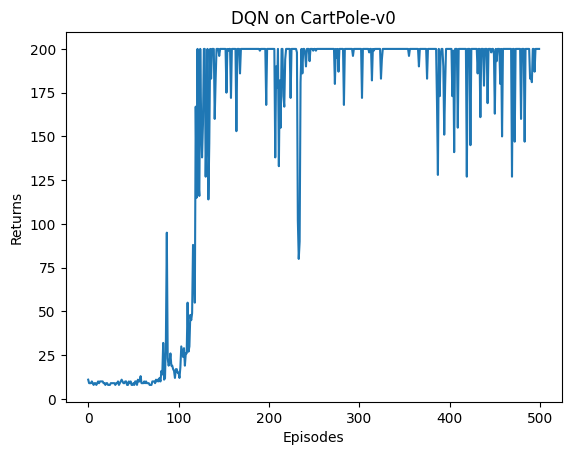

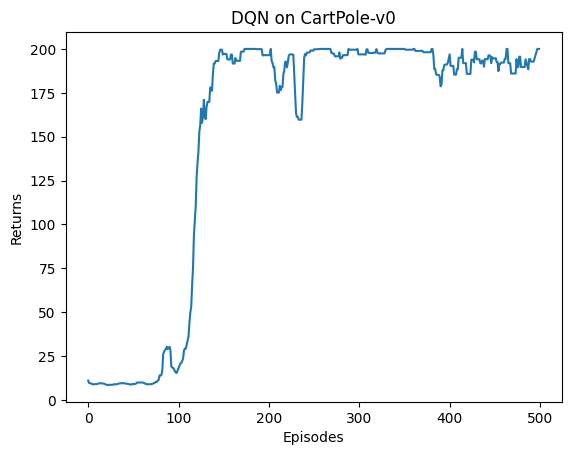

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()